## Milestone 3: Make corpus and Data Visualization Full Solution

We are going to further explore the now processed texts. There are different ways to explore text-based data, some of the most common techniques include:
- generate word clouds
- plot the most common words
- plot the most common N-grams
- topic modeling with LDA using Gensim and visualization using pyLDAvis

In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./preprocessed.csv',index_col=0)

### Workflow 1: Convert processed text into a corpus

In [5]:
df['reply_preprocessed']= df['reply_preprocessed'].apply(eval)

In [6]:
df['reply_tokenized']= df['reply_tokenized'].apply(eval)

In [7]:
df['reply_tokenized'].head()

0      [im, getting, ton, bugs, 5, well, snappy, lines, response, times, reason, ability, sync, google, drive, download, multiple, files, google, drive, gone, think, need, time, cope, new, launch]
1                                                                                                 [goodnotes, 5, yet, compatible, desktop, app, says, release, notes, features, added, near, future]
2                                                       [havent, downloaded, gn5, yet, watched, walkthrough, see, theres, snap, option, check, uncheck, think, somewhere, pen, options, hope, helps]
3                                                                                                                                                          [sounds, lot, like, whats, going, thanks]
4    [probably, stick, goodnotes, 4, noticed, goodnotes, 5, easy, way, export, notes, dropbox, pdf, format, love, available, nonapple, devices, ie, complaint, expect, gn, 5, mature, get, features]
Name: reply_tok

### Workflow 2: Filter noun tokens

In [10]:
import nltk

In [11]:
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]#,'ADJ','JJS']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [12]:
df['reply_noun_verb'] = df['reply_tokenized'].map(noun_only)

In [13]:
df.submission_link_flair_text.value_counts()

Question - iPad      1082
Templates             500
Question - Other      253
Review                225
Question - Mac         61
Stylus problems        54
Question - iPhone      47
Name: submission_link_flair_text, dtype: int64

### Workflow 3: Split the dataframe by topics

In [14]:
grouped = df.groupby(df.submission_link_flair_text)

In [15]:
grouped_df_dict = {}

for name in list(df.submission_link_flair_text.unique()):
    if type(name) ==str :
        grouped_df_dict[name] = grouped.get_group(name)

### Workflow 4: Create most-common-words, N-grams, and wordcloud

In [16]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n):
    vec = CountVectorizer(tokenizer=lambda text: text,
                          ngram_range=(n, n),
                         lowercase=False).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [17]:
# looking at top bigram
def graph_ngrams(corpus = df['reply_tokenized'], topn=30, ngram=1,axis_num=0):
    top_n_bigrams=get_top_ngram(corpus, ngram)[:topn]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x,ax=axs[axis_num])

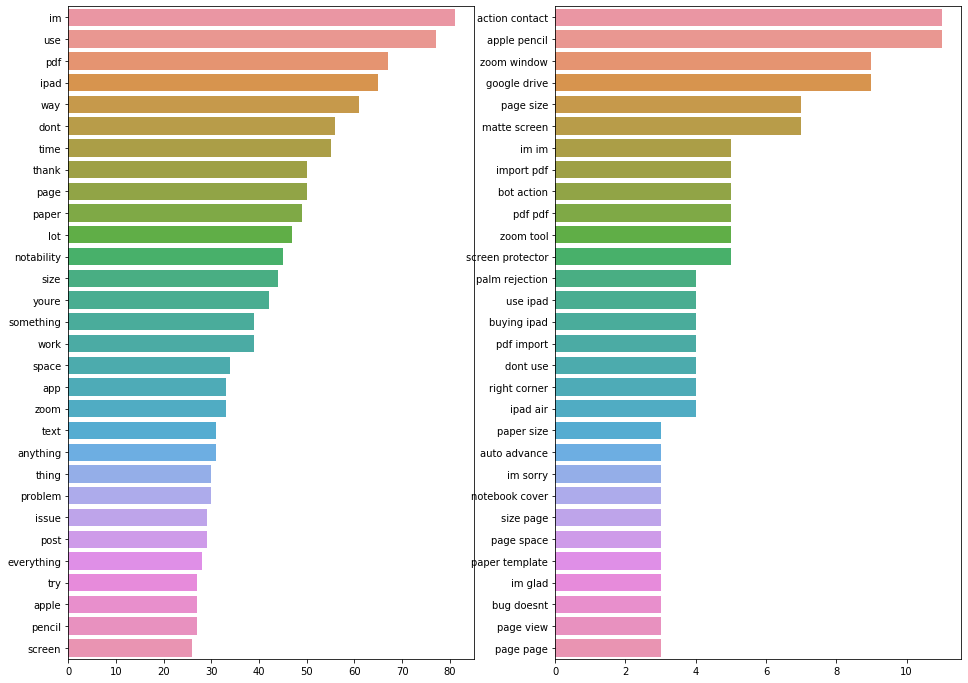

In [18]:
fig, axs = plt.subplots(1,2,figsize=(16,12))

graph_ngrams(corpus = grouped_df_dict['Question - iPad']['reply_noun_verb'],ngram=1,axis_num=0)
graph_ngrams(corpus = grouped_df_dict['Question - iPad']['reply_noun_verb'],ngram=2,axis_num=1)


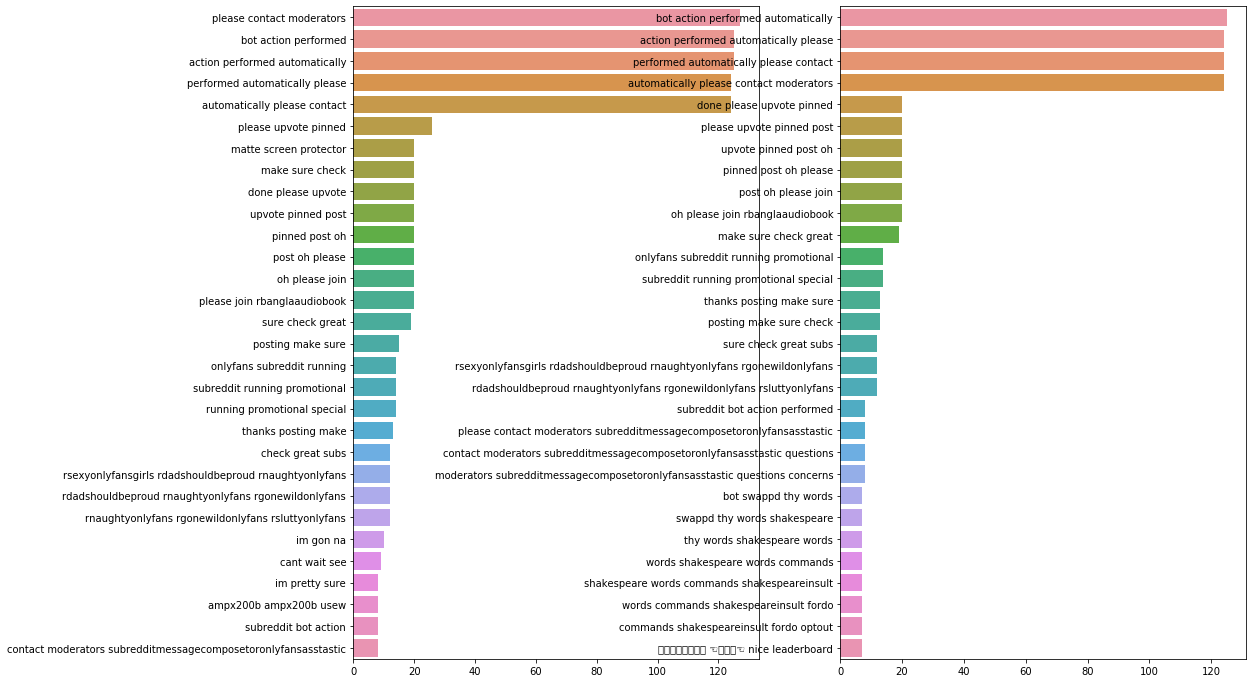

In [19]:
fig, axs = plt.subplots(1,2,figsize=(16,12))

graph_ngrams(ngram=3,axis_num=0)
graph_ngrams(ngram=4,axis_num=1)


#### Word clouds

In [20]:
from wordcloud import WordCloud

In [21]:
wordcloud = WordCloud(background_color='white').generate(str(grouped_df_dict['Question - iPad']['reply_noun_verb']))

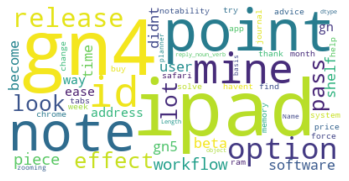

In [22]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Workflow 6: Topic modeling with Gensim

In [23]:
grouped_df_dict.keys()

dict_keys(['Review', 'Question - iPad', 'Question - Other', 'Question - Mac', 'Stylus problems', 'Templates', 'Question - iPhone'])

In [24]:
import gensim

def generate_topic_modeling(df,num_topic=4):
    corpus=[]
    for word_list in df['reply_noun_verb']:
        corpus.append(word_list)
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = num_topic, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    lda_model.show_topics()
    
    return lda_model, bow_corpus, dic

In [25]:
def calculate_coherence(df):
    coherence = []
    corpus=[]
    for word_list in df['reply_noun_verb']:
        corpus.append(word_list)
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    for k in range(5,25):
        print('Round: '+str(k))
        Lda = gensim.models.ldamodel.LdaModel
        ldamodel = Lda(bow_corpus, num_topics=k, id2word = dic, passes=10,\
                       iterations=200, chunksize = 10000, eval_every = None)

        cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts= df['reply_noun_verb'],\
                                                         dictionary=dic, coherence='c_v')
        coherence.append((k,cm.get_coherence()))
    return coherence

In [26]:
def lda_elbow_plot(df):
    coherence = calculate_coherence(df)
    x_val = [x[0] for x in coherence]
    y_val = [x[1] for x in coherence]
    plt.plot(x_val,y_val)
    plt.scatter(x_val,y_val)
    plt.title('Number of Topics vs. Coherence')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.xticks(x_val)
    plt.show()

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


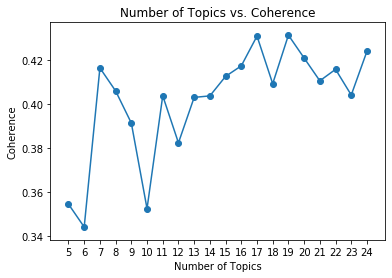

In [27]:
lda_elbow_plot(grouped_df_dict['Question - iPad'])

In [46]:
topic_lda_model, topic_bow_corpus, topic_dic = generate_topic_modeling(\
                            grouped_df_dict['Review'],num_topic=7)
topic_lda_model.show_topics()

[(0,
  '0.035*"thank" + 0.016*"post" + 0.016*"im" + 0.016*"research" + 0.016*"class" + 0.012*"function" + 0.012*"zoom" + 0.012*"bug" + 0.008*"please" + 0.008*"time"'),
 (1,
  '0.025*"change" + 0.017*"price" + 0.017*"part" + 0.013*"time" + 0.013*"stuff" + 0.013*"everything" + 0.013*"way" + 0.009*"thank" + 0.009*"day" + 0.009*"tomorrow"'),
 (2,
  '0.031*"shape" + 0.020*"please" + 0.012*"rectangle" + 0.012*"fill" + 0.012*"highlighter" + 0.008*"pencil" + 0.008*"lot" + 0.008*"random" + 0.008*"history" + 0.008*"use"'),
 (3,
  '0.031*"size" + 0.024*"use" + 0.016*"vote" + 0.012*"color" + 0.012*"trump" + 0.012*"page" + 0.012*"thank" + 0.012*"love" + 0.012*"zoom" + 0.008*"class"'),
 (4,
  '0.018*"post" + 0.018*"time" + 0.014*"link" + 0.014*"im" + 0.014*"action" + 0.014*"bot" + 0.014*"contact" + 0.014*"check" + 0.014*"video" + 0.014*"subreddit"'),
 (5,
  '0.027*"wow" + 0.017*"feel" + 0.011*"im" + 0.011*"thank" + 0.011*"man" + 0.011*"issue" + 0.011*"everything" + 0.011*"damn" + 0.011*"ipad" + 0.01

### Workflow 7: Use pyLDAvis for visualization the LDA result

In [29]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [47]:
topic_lda_viz = gensimvis.prepare(topic_lda_model, topic_bow_corpus, topic_dic)

In [48]:
pyLDAvis.display(topic_lda_viz)

Findings:
1. In one of the distinct topics, people mention about `bugs` and then extend `thank` a lot. In relation to bugs, the words `support`, `concern` and `assistance` show up distinctly in topics. It suggests that at this subthreads, people complain about problems they have with good notes and voice the concerns and provide a user group support for each other.
2. Another topic contain words talk about the tools within the app such as `highlight`, `shadow`, `size`. It shows that subredditers are putting their feedback about functionality of the app in the thread.

### Workflow 8: Export LDA visualization as HTML

In [32]:
pyLDAvis.save_html(topic_lda_viz, 'lda.html')